In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
불필요한 열 제거, 특정 ID 변수를 categorical type으로 변경

In [3]:
# 불필요한 열
col_notuse = ['ADID', '노출 ID', 'SSP 입찰ID', 'DSP 입찰ID', 'AX 낙찰ID', 'WUID (웹 유저 ID)', '광고 응답 광고주 도메인','OS 버전 ID']
col_use = ['시각', 'ADID 타입', 'DSP ID', '매체 ID', '애드유닛 ID', '플랫폼', 'OS 종류', '사이즈 ID',
       '환율', '광고 응답 소재 카테고리', '국가코드 ID', 'P1', 'P2', 'P3', 'P4', 'P5',
       'winning']

In [5]:
# # chunk to pickle(train dataset)
# tp = pd.read_csv('dataset_round1/round1_train.csv', iterator=True, chunksize=1000000)
# df = pd.concat(tp, ignore_index=True)
# # df.to_pickle('train_full.pkl')

In [10]:
# # Data Load/save는 pickle format 이용함
# df = pd.read_pickle('train_full.pkl')

전체 데이터 중
* 낙찰 O : 약 200만개
* 낙찰 X : 약 530만개

> binary classification

### 불필요한 열 제거

In [30]:
# df.columns

Index(['시각', 'ADID', 'ADID 타입', 'DSP ID', '매체 ID', '애드유닛 ID', '플랫폼', 'OS 종류',
       '사이즈 ID', '노출 ID', 'SSP 입찰ID', 'DSP 입찰ID', 'AX 낙찰ID', 'WUID (웹 유저 ID)',
       '환율', '광고 응답 소재 카테고리', '광고 응답 광고주 도메인', '국가코드 ID', 'OS 버전 ID', 'P1',
       'P2', 'P3', 'P4', 'P5', 'winning'],
      dtype='object')

In [36]:
# for col in df.columns[:-6]:
#     print(f'Unique num of column {col} : {len(df[col].unique())}')

Unique num of column 시각 : 516518
Unique num of column ADID : 462115
Unique num of column ADID 타입 : 4
Unique num of column DSP ID : 7
Unique num of column 매체 ID : 385
Unique num of column 애드유닛 ID : 813
Unique num of column 플랫폼 : 3
Unique num of column OS 종류 : 2
Unique num of column 사이즈 ID : 3
Unique num of column 노출 ID : 7350237
Unique num of column SSP 입찰ID : 7377207
Unique num of column DSP 입찰ID : 6654374
Unique num of column AX 낙찰ID : 7377207
Unique num of column WUID (웹 유저 ID) : 174181
Unique num of column 환율 : 5
Unique num of column 광고 응답 소재 카테고리 : 139
Unique num of column 광고 응답 광고주 도메인 : 2312
Unique num of column 국가코드 ID : 30
Unique num of column OS 버전 ID : 13


Drop cols : ADID, 노출 ID, SSP 입찰ID, DSP 입찰ID, AX 낙찰ID, WUID (웹 유저 ID), 도메인, OS 버전 ID

In [45]:
# df_cols = df.columns.drop(col_notuse)

In [46]:
# df = df[df_cols]

In [47]:
# df.to_pickle('train.pkl') # 4.3s(compressed)

### ID cols to categorical coding

In [6]:
df = pd.read_csv('dataset_round1/round1_train.csv', usecols=col_use)

In [7]:
df_test = pd.read_csv('dataset_round1/round1_test.csv', usecols=df.columns.drop(['P5','winning']))

In [13]:
# DSP ID, 매체 ID, 애드유닛 ID to categorical(from ID to integer)
col_cat = ['DSP ID', '매체 ID', '애드유닛 ID']

In [14]:
from pandas.api.types import CategoricalDtype
from copy import deepcopy

for col in col_cat:
    series_whole = pd.concat([df[col],df_test[col]]).astype('category').cat.codes + 1
    df[col] = series_whole[:len(df)]
    df_test[col] = series_whole[len(df):]

In [15]:
df = df.sort_values(by=['시각','winning'])
df_test = df_test.sort_values(by=['시각'])

In [16]:
df = df.reset_index(drop=True)

In [17]:
df.to_pickle('train.pkl') 
df_test.to_pickle('test.pkl') # 1.6s

## EDA

In [27]:
# Data Load
df_train = pd.read_pickle('train.pkl')
df_train = df_train[df_train.columns.drop(['P5'])]

df_test = pd.read_pickle('test.pkl')

In [22]:
col_price = ['P1','P2','P3','P4']

In [28]:
df_train.loc[df_train.winning==1.0, col_price].corr()

,P1,P2,P3,P4
P1,1.000000,0.583035,0.646734,0.999998
P2,0.583035,1.000000,0.949854,0.582976
P3,0.646734,0.949854,1.000000,0.646683
P4,0.999998,0.582976,0.646683,1.000000


In [29]:
df_train.loc[df_train.winning==0.0, col_price].corr()

,P1,P2,P3,P4
P1,1.000000,0.713607,0.715692,0.999274
P2,0.713607,1.000000,0.995936,0.728211
P3,0.715692,0.995936,1.000000,0.729967
P4,0.999274,0.728211,0.729967,1.000000


In [31]:
df_train.columns

Index(['시각', 'ADID 타입', 'DSP ID', '매체 ID', '애드유닛 ID', '플랫폼', 'OS 종류', '사이즈 ID',
       '환율', '광고 응답 소재 카테고리', '국가코드 ID', 'P1', 'P2', 'P3', 'P4', 'winning'],
      dtype='object')

### Visualization

In [49]:
df_win = df_train[df_train.winning==1.0]
df_lose = df_train[df_train.winning==0.0]

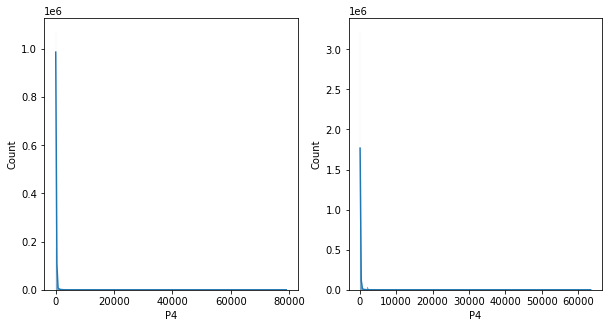

In [85]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.histplot(df_win, x='P4',bins=1000, kde=True, ax=axes[0])
sns.histplot(df_lose, x='P4',bins=1000, kde=True, ax=axes[1])
plt.show()

In [77]:
# If normalized?
df_norm = deepcopy(df_train)
df_minmax = deepcopy(df_train)

for col in col_price:
    df_norm[col] = (df_norm[col]-df_norm[col].mean())/df_norm[col].std()
    df_minmax[col] = (df_minmax[col]-df_minmax[col].min())/(df_minmax[col].max()-df_minmax[col].min())

In [78]:
df_norm_win = df_norm[df_train.winning==1.0]
df_norm_lose = df_norm[df_train.winning==0.0]

df_minmax_win = df_minmax[df_train.winning==1.0]
df_minmax_lose = df_minmax[df_train.winning==0.0]

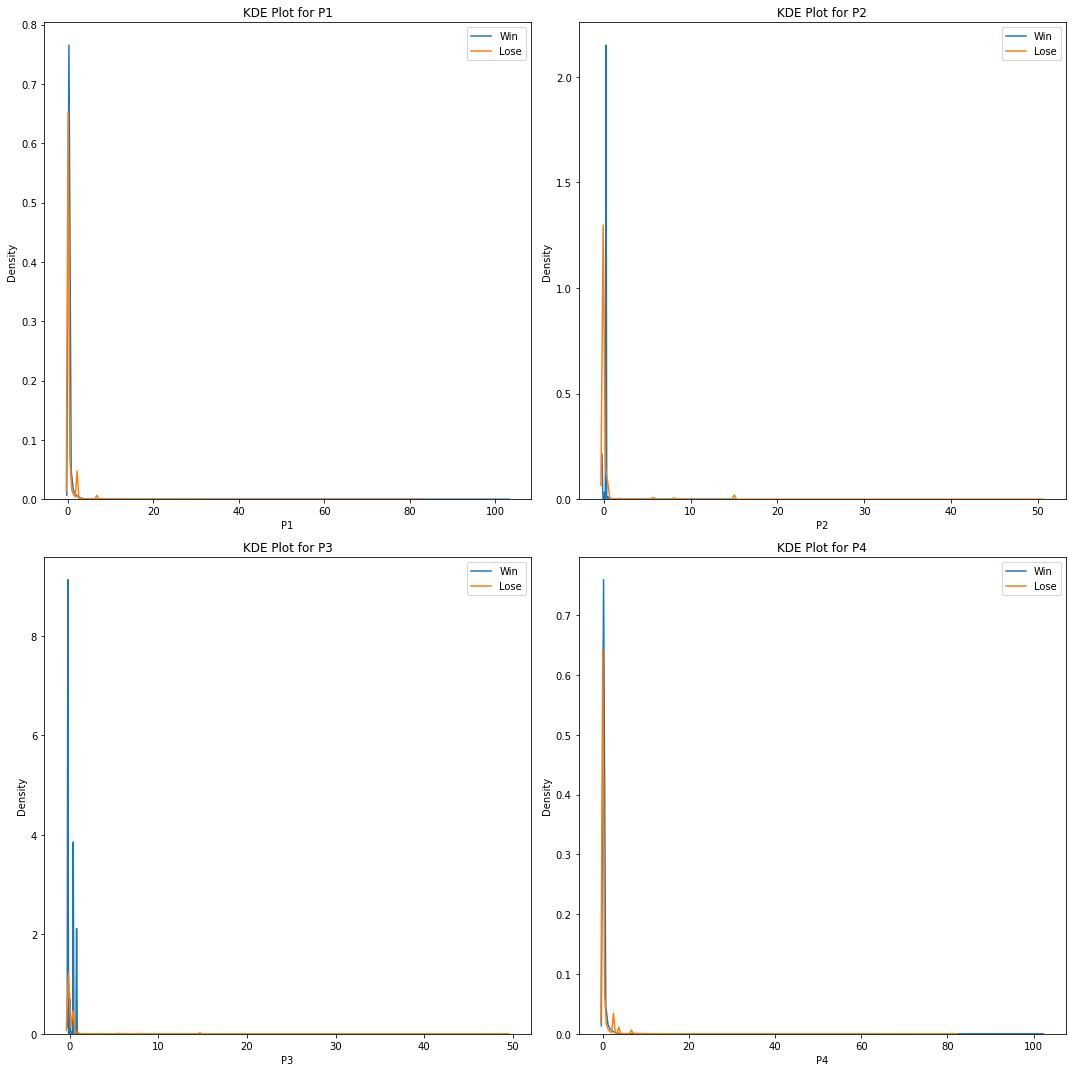

In [111]:
# Mean-Normalized
fig, axes = plt.subplots(2,2,figsize=(15,15))
for idx, col in enumerate(col_price):
    sns.kdeplot(df_norm_win[col], label='Win', ax=axes[idx//2, idx%2])
    sns.kdeplot(df_norm_lose[col], label='Lose', ax=axes[idx//2, idx%2])
    axes[idx//2,idx%2].legend()
    axes[idx//2,idx%2].set_title(f'KDE Plot for {col}')
plt.tight_layout()
plt.show()

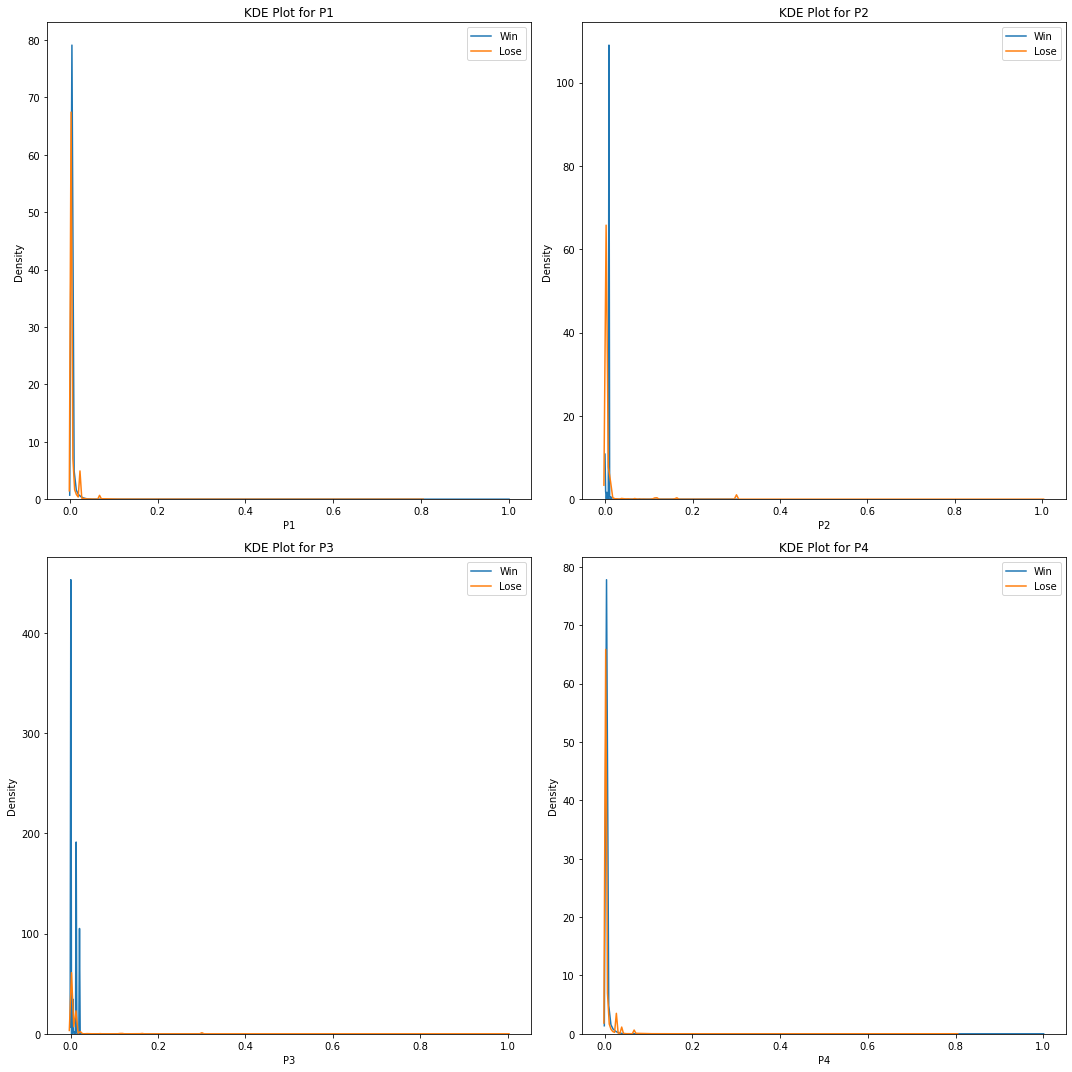

In [112]:
# Minimax-Normalized
fig, axes = plt.subplots(2,2,figsize=(15,15))
for idx, col in enumerate(col_price):
    sns.kdeplot(df_minmax_win[col], label='Win', ax=axes[idx//2, idx%2])
    sns.kdeplot(df_minmax_lose[col], label='Lose', ax=axes[idx//2, idx%2])
    axes[idx//2,idx%2].legend()
    axes[idx//2,idx%2].set_title(f'KDE Plot for {col}')
plt.tight_layout()
plt.show()

Logarithm

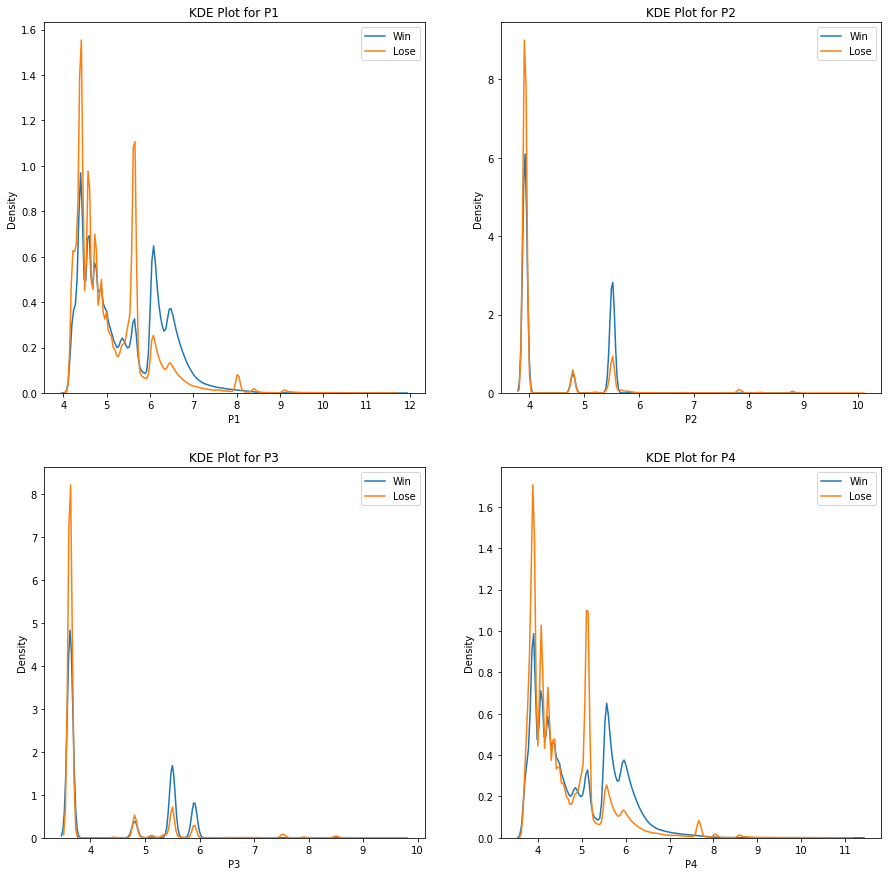

In [109]:
fig, axes = plt.subplots(2,2,figsize=(15,15))
for idx, col in enumerate(col_price):
    sns.kdeplot(np.log1p(df_win[col]), label='Win', ax=axes[idx//2, idx%2])
    sns.kdeplot(np.log1p(df_lose[col]), label='Lose', ax=axes[idx//2, idx%2])
    axes[idx//2,idx%2].legend()
    axes[idx//2,idx%2].set_title(f'KDE Plot for {col}')
plt.tight_layout()
plt.show()

최종 : P1-P4 데이터에 대해 log1p 변환 실행

In [113]:
for col in col_price:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])

In [118]:
df_train.to_pickle('train.pkl') 
df_test.to_pickle('test.pkl') # 1.6s

Category 없는 데이터가 많음 > 사용불가하다고 판단

또는 카테고리가 있는 데이터와 없는 데이터를 나누어 성능 비교

In [126]:
df_train['광고 응답 소재 카테고리'].isna().sum()

4948647

In [128]:
df_train[df_train['광고 응답 소재 카테고리'].isna()]

,시각,ADID 타입,DSP ID,매체 ID,애드유닛 ID,플랫폼,OS 종류,사이즈 ID,환율,광고 응답 소재 카테고리,국가코드 ID,P1,P2,P3,P4,winning
3,20220403000000,5,6,203,248,3,1,3,1218.0,NaN,1012.0,6.180696,5.525455,5.499624,5.671248,1
4,20220403000000,1,6,379,635,1,1,2,1218.0,NaN,1012.0,7.095744,3.918581,3.625407,6.585471,1
6,20220403000001,1,3,144,859,1,1,1,1218.0,NaN,1012.0,4.630612,3.918581,3.625407,4.126264,0
7,20220403000001,1,6,144,859,1,1,1,1218.0,NaN,1012.0,4.981539,3.918581,3.625407,4.475278,0
8,20220403000001,1,6,144,859,1,1,1,1218.0,NaN,1012.0,4.732183,3.918581,3.625407,4.227212,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377202,20220408235959,1,6,144,859,1,1,1,1220.5,NaN,1012.0,4.401253,3.920591,3.627403,3.898569,1
7377203,20220408235959,5,6,203,248,3,1,3,1220.5,NaN,1012.0,6.077611,5.525457,5.501666,5.568313,1
7377204,20220408235959,1,6,144,859,1,1,1,1220.5,NaN,1012.0,4.581529,3.920591,3.627403,4.077506,1
7377205,20220408235959,1,3,105,54,1,1,1,1220.5,NaN,1012.0,4.271007,3.920591,3.627403,3.769450,1
